#                                  CGM Time Series Analysis



In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

## Importing the data into the notebook

In [113]:
# reading in my CGM data and storing as a csv
url = "AbdulnourDualeh_glucose_19-3-2024.csv"

In [114]:
# storing the csv data in a pandas dataframe
df = pd.read_csv(url, header=1)

In [115]:
 # printing the first 5 rows of data to inspect it
df.head(5)

,Device,Serial Number,Device Timestamp,Record Type,Historic Glucose mmol/L,Scan Glucose mmol/L,Non-numeric Rapid-Acting Insulin,Rapid-Acting Insulin (units),Non-numeric Food,Carbohydrates (grams),Carbohydrates (servings),Non-numeric Long-Acting Insulin,Long-Acting Insulin Value (units),Notes,Strip Glucose mmol/L,Ketone mmol/L,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units)
0,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 10:41,0,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 10:56,0,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 11:11,0,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 11:26,0,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 11:41,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning and preparing the data

In [116]:
 # Summary of the columns and their dtypes. we can see that he wrong information is stored in the columns
print(df.info())
# getting all column names
print(df.columns)

# dropping all unneccasary columns which are not required for the analysis
df.drop(['Device', 'Serial Number', 'Record Type',
         'Non-numeric Rapid-Acting Insulin', 'Historic Glucose mmol/L', 'Rapid-Acting Insulin (units)',
         'Non-numeric Food', 'Carbohydrates (grams)', 'Carbohydrates (servings)',
         'Non-numeric Long-Acting Insulin', 'Long-Acting Insulin Value (units)',
         'Notes', 'Strip Glucose mmol/L', 'Ketone mmol/L',
         'Meal Insulin (units)', 'Correction Insulin (units)',
         'User Change Insulin (units)'], axis=1, inplace=True)

#Formating the 'Device Timestamp' column into datetime type and also into the dd-mm-yyyy HH:MM format
df['Device Timestamp'] = pd.to_datetime(df['Device Timestamp'], format='%d-%m-%Y %H:%M')

# checking the sum of na columns, its a large amount but seeing as we are only dealing with the last 6 months we can drop the data
print(f"The total count of null values: {df['Scan Glucose mmol/L'].isna().sum()}")

df.dropna(inplace=True)  # dropping the null columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54127 entries, 0 to 54126
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Device                             54127 non-null  object 
 1   Serial Number                      54127 non-null  object 
 2   Device Timestamp                   54127 non-null  object 
 3   Record Type                        54127 non-null  int64  
 4   Historic Glucose mmol/L            38907 non-null  float64
 5   Scan Glucose mmol/L                11298 non-null  float64
 6   Non-numeric Rapid-Acting Insulin   0 non-null      float64
 7   Rapid-Acting Insulin (units)       1 non-null      float64
 8   Non-numeric Food                   0 non-null      float64
 9   Carbohydrates (grams)              2 non-null      float64
 10  Carbohydrates (servings)           0 non-null      float64
 11  Non-numeric Long-Acting Insulin    0 non-null      flo

## Filtering data for the last 6 months

In [117]:
max_date = df['Device Timestamp'].iloc[-1]

# Calculate the date 6 months before the maximum date
six_months_ago = max_date - pd.DateOffset(months=6)

# Filter the DataFrame to include only the data from the last 6 months based on 'Device Timestamp'
df = df[df['Device Timestamp'] > six_months_ago]

df.set_index('Device Timestamp', inplace=True)  # setting the index as the time stamp

## Statistical Analysis

#### Function to get Sumary statistics

In [118]:
def summarize_glucose(df):
    # Ensure the glucose readings column is in the correct format
    if df.columns[0] != 'Scan Glucose mmol/L':
        print("Please ensure your DataFrame's only column is 'Scan Glucose mmol/L'")
        return

    # Calculate quantiles
    quantiles = df['Scan Glucose mmol/L'].quantile([0.25, 0.5, 0.75])

    # Calculate IQR
    iqr = quantiles[0.75] - quantiles[0.25]

    summary = {
        'min': df['Scan Glucose mmol/L'].min(),
        'max': df['Scan Glucose mmol/L'].max(),
        'mode': mode(df['Scan Glucose mmol/L'])[0][0],
        'median': df['Scan Glucose mmol/L'].median(),
        'mean': df['Scan Glucose mmol/L'].mean(),
        'std_dev': df['Scan Glucose mmol/L'].std(),
        'quantiles': quantiles.to_dict(),
        'IQR': iqr  # Correctly calculated IQR
    }

    return summary

#### Function to find outliers using the IQR

In [119]:
def find_glucose_outliers(df):
    if 'Scan Glucose mmol/L' not in df.columns:
        print("The DataFrame does not contain the column 'Scan Glucose mmol/L'.")
        return

    # Ensure the column is in numeric format, with coercion of errors
    df['Scan Glucose mmol/L'] = pd.to_numeric(df['Scan Glucose mmol/L'], errors='coerce')

    # Calculate the quantiles and IQR
    Q1 = df['Scan Glucose mmol/L'].quantile(0.25)
    Q3 = df['Scan Glucose mmol/L'].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the lower and upper fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df['Scan Glucose mmol/L'] < lower_fence) | (df['Scan Glucose mmol/L'] > upper_fence)]

    # Return a dictionary with outlier information
    outlier_info = {
        'lower_fence': lower_fence,
        'upper_fence': upper_fence,
        'outliers': outliers,
        'outliers_count': outliers.shape[0]
    }

    return outlier_info

### EDA

In [120]:
# This function gives us summary statistics for our dataset

summarize_glucose(df)

{'min': 2.9,
 'max': 25.4,
 'mode': 8.3,
 'median': 9.0,
 'mean': 9.47311239811237,
 'std_dev': 3.2666463151790204,
 'quantiles': {0.25: 7.0, 0.5: 9.0, 0.75: 11.6},
 'IQR': 4.6}

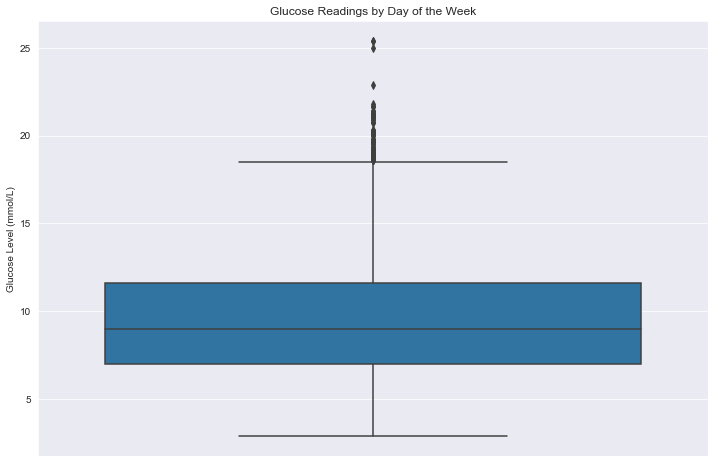

In [121]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, y="Scan Glucose mmol/L")

plt.title('Glucose Readings by Day of the Week')
plt.ylabel('Glucose Level (mmol/L)')
plt.xticks(rotation=45)  # Improve readability of the x-axis labels
plt.show()

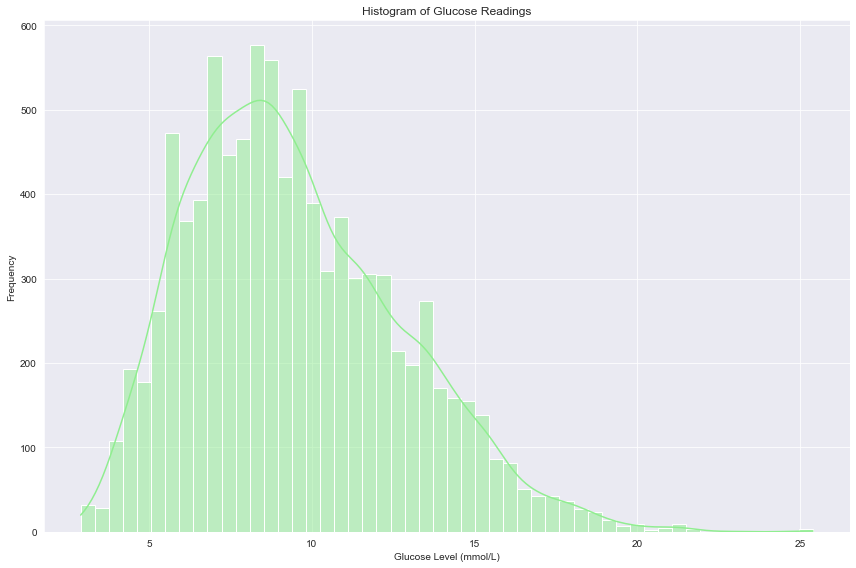

In [122]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df['Scan Glucose mmol/L'], kde=True, color='lightgreen')
plt.title('Histogram of Glucose Readings')
plt.xlabel('Glucose Level (mmol/L)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Time series Analysis

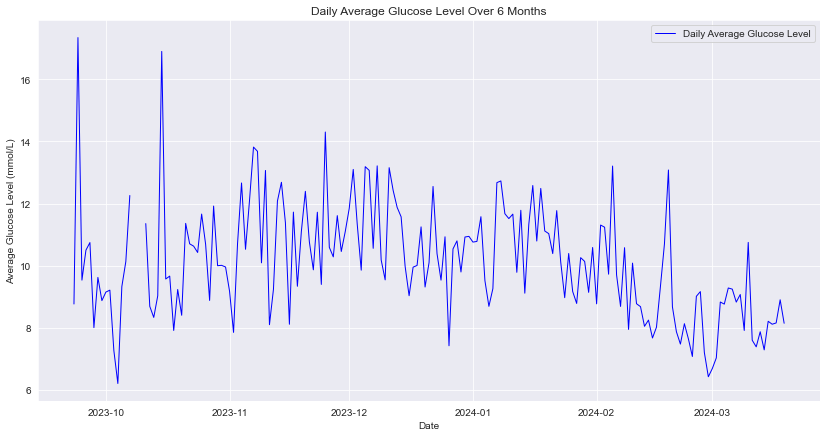

In [123]:
# Calculate daily averages if there are multiple readings per day

daily_avg = df.resample('D').mean()

plt.figure(figsize=(14, 7))
plt.plot(daily_avg.index, daily_avg['Scan Glucose mmol/L'], label='Daily Average Glucose Level', color='blue',
         linewidth=1)

plt.title('Daily Average Glucose Level Over 6 Months')
plt.xlabel('Date')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Average Glucose Level (mmol/L)')

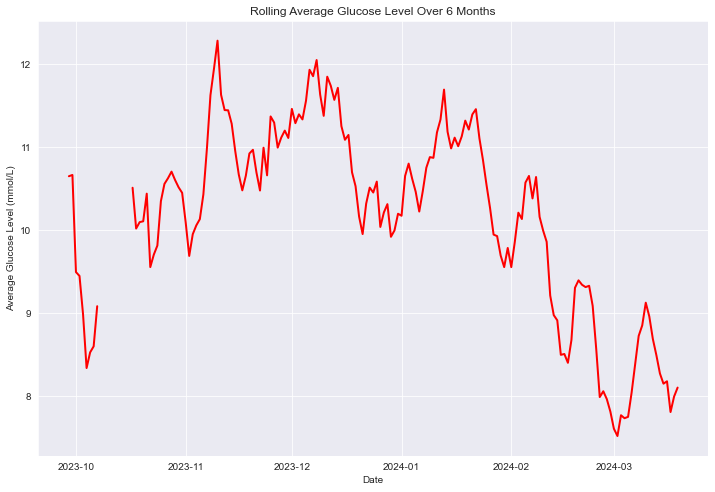

In [124]:
rolling_avg = daily_avg['Scan Glucose mmol/L'].rolling(window=7).mean()  # 7-day rolling average
plt.figure(figsize=(12, 8))
plt.plot(daily_avg.index, rolling_avg, label='7-Day Rolling Average', color='red', linewidth=2)

plt.title('Rolling Average Glucose Level Over 6 Months')
plt.xlabel('Date')
plt.ylabel('Average Glucose Level (mmol/L)')

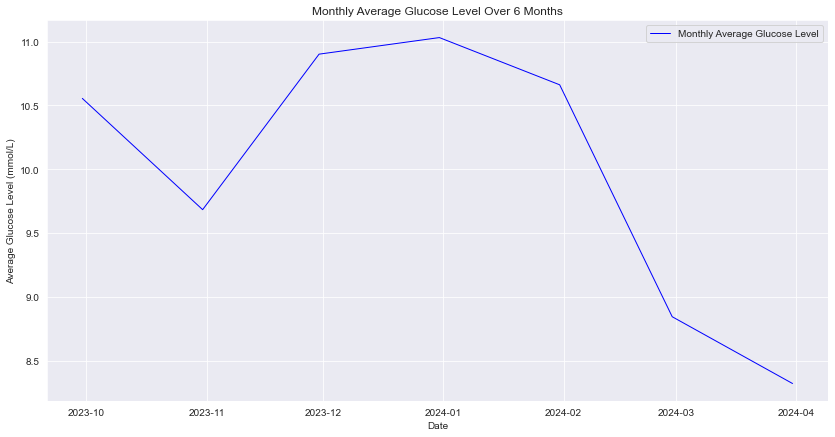

In [125]:
# Calculate daily averages if there are multiple readings per day
monthly_avg = df.resample('M').mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_avg.index, monthly_avg['Scan Glucose mmol/L'], label='Monthly Average Glucose Level', color='blue',
         linewidth=1)

plt.title('Monthly Average Glucose Level Over 6 Months')
plt.xlabel('Date')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.legend()
plt.grid(True)
plt.show()

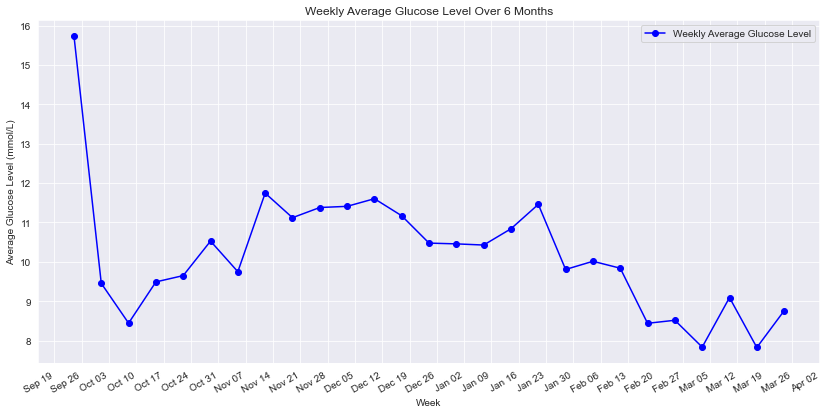

In [126]:
weekly_avg = df.resample('W').mean()
plt.figure(figsize=(14, 7))
plt.plot(weekly_avg.index, weekly_avg['Scan Glucose mmol/L'], marker='o', linestyle='-', color='blue',
         label='Weekly Average Glucose Level')

# Improve the x-axis to show months more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()  # Rotation

plt.title('Weekly Average Glucose Level Over 6 Months')
plt.xlabel('Week')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.legend()
plt.grid(True)

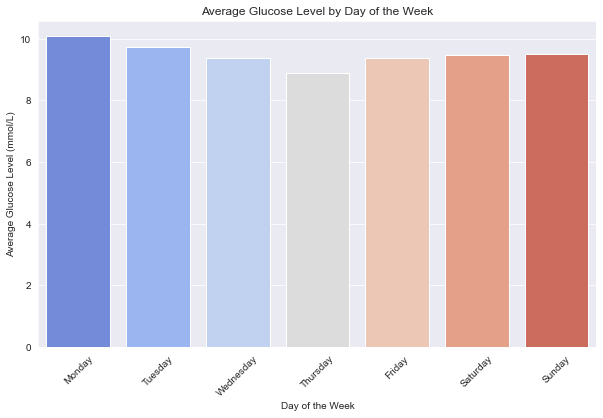

In [127]:
df['day_of_week'] = df.index.day_name()  # Add a column with the day name
daily_avg = df.groupby('day_of_week')['Scan Glucose mmol/L'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.barplot(x=daily_avg.index, y=daily_avg.values, palette='coolwarm')
plt.title('Average Glucose Level by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.xticks(rotation=45)
plt.show()

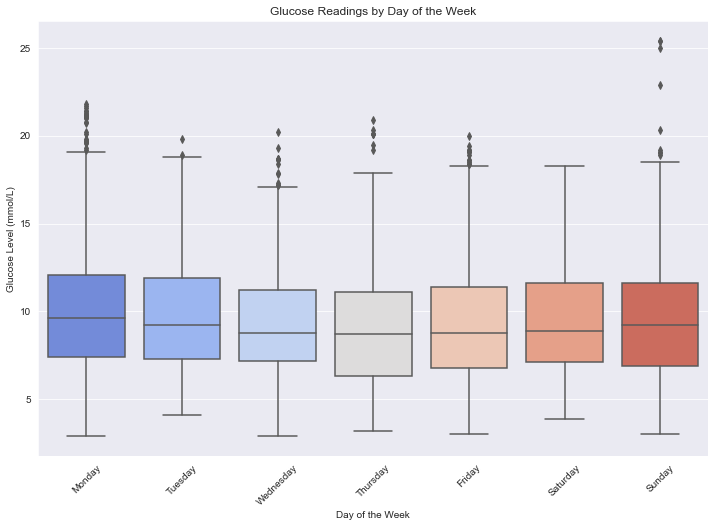

In [128]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='day_of_week', y='Scan Glucose mmol/L', data=df, palette="coolwarm",
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.title('Glucose Readings by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Glucose Level (mmol/L)')
plt.xticks(rotation=45)  # Improve readability of the x-axis labels
plt.show()

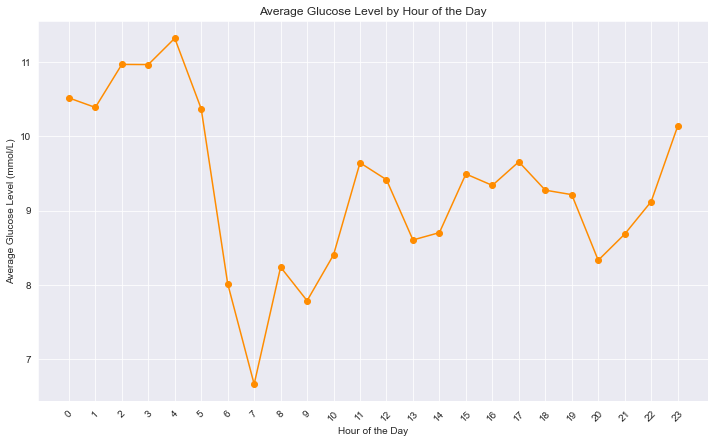

In [129]:
df['hour_of_day'] = df.index.hour  # Adding a column with the hour of the day
hourly_avg = df.groupby('hour_of_day')['Scan Glucose mmol/L'].mean()

# Plotting
plt.figure(figsize=(12, 7))
hourly_avg.plot(kind='line', marker='o', linestyle='-', color='darkorange')
plt.title('Average Glucose Level by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.xticks(range(0, 24), rotation=45)  # Ensure x-ticks for every hour
plt.grid(True)
plt.show()

## Time series Forecasting

### Arima Model for Forecasting Blood sugar for hourly intervals

#### Resampling and Imputing data using KNN and linear 

                     Scan Glucose mmol/L  hour_of_day
Device Timestamp                                     
2023-09-23 17:00:00                 16.8         17.0
2023-09-23 18:00:00                  NaN          NaN
2023-09-23 19:00:00                  NaN          NaN
2023-09-23 20:00:00                  NaN          NaN
2023-09-23 21:00:00                  4.8         21.0
2023-09-23 22:00:00                  NaN          NaN
2023-09-23 23:00:00                  NaN          NaN
2023-09-24 00:00:00                  NaN          NaN
2023-09-24 01:00:00                  NaN          NaN
2023-09-24 02:00:00                  NaN          NaN

Percentage of NA samples = 48.64%


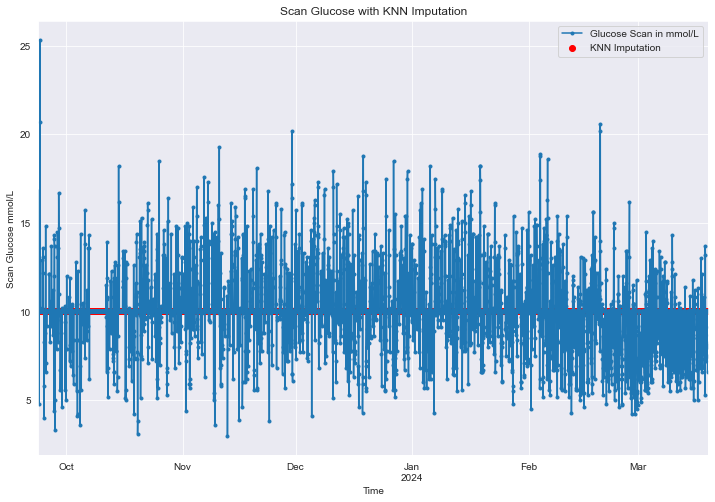

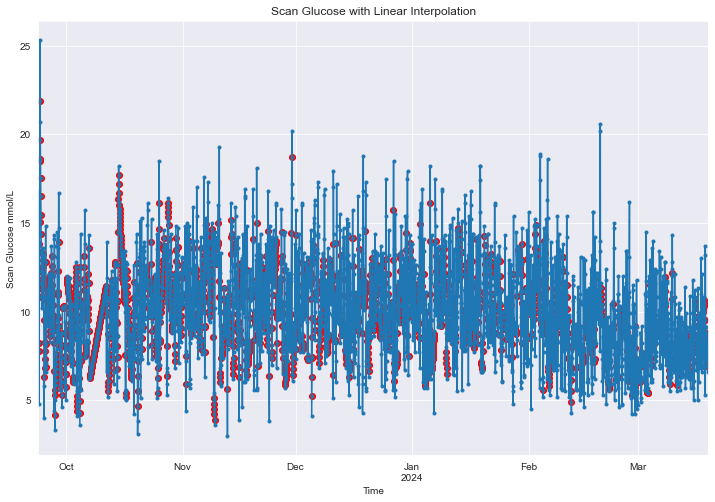

In [130]:
# Resampling my timeseries data
hourly_avg = df.resample('60T').mean().round(1)
print(hourly_avg.head(10))

# Checking
total = len(hourly_avg)
missing = hourly_avg['Scan Glucose mmol/L'].isna().sum()
print(f"\nPercentage of NA samples = {round(((missing / total) * 100), 2)}%")

# Imputation using KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
df_imputed_knn = hourly_avg.copy()
df_imputed_knn[['Scan Glucose mmol/L']] = imputer.fit_transform(df_imputed_knn[['Scan Glucose mmol/L']])

# Create a matplotlib plot
plt.figure(figsize=(12,8))
df_imputed_knn['Scan Glucose mmol/L'].plot(style='.-', label='Glucose Scan in mmol/L')

# Add points where data was imputed
imputed_indices = hourly_avg[hourly_avg['Scan Glucose mmol/L'].isnull()].index
plt.scatter(imputed_indices, df_imputed_knn.loc[imputed_indices, 'Scan Glucose mmol/L'], color='red', label='KNN Imputation')

# Set title and labels
plt.title('Scan Glucose with KNN Imputation')
plt.xlabel('Time')
plt.ylabel('Scan Glucose mmol/L')
plt.legend()
plt.show()

# Imputation using linear interpolation
df_imputed_linear = hourly_avg.interpolate(method='linear', limit_direction='forward')

# Plot the main line with markers
df_imputed_linear['Scan Glucose mmol/L'].plot(style='.-', figsize=(12,8), title='Scan Glucose with Linear Interpolation')

# Add points where data was imputed with red color
plt.scatter(imputed_indices, df_imputed_linear.loc[imputed_indices, 'Scan Glucose mmol/L'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Scan Glucose mmol/L')
plt.show()

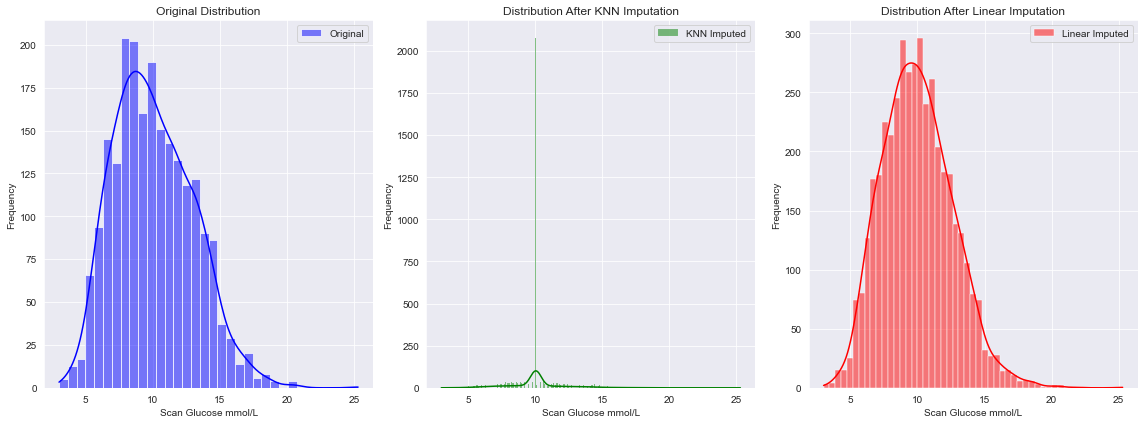

In [131]:
# Plotting the distribution before imputation
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st subplot
sns.histplot(hourly_avg['Scan Glucose mmol/L'].dropna(), kde=True, color="blue", label="Original")
plt.title('Original Distribution')
plt.xlabel('Scan Glucose mmol/L')
plt.ylabel('Frequency')
plt.legend()

# Plotting the distribution after KNN imputation
plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd subplot
sns.histplot(df_imputed_knn['Scan Glucose mmol/L'], kde=True, color="green", label="KNN Imputed")
plt.title('Distribution After KNN Imputation')
plt.xlabel('Scan Glucose mmol/L')
plt.ylabel('Frequency')
plt.legend()

# Plotting the distribution after linear imputation
plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd subplot
sns.histplot(df_imputed_linear['Scan Glucose mmol/L'], kde=True, color="red", label="Linear Imputed")
plt.title('Distribution After Linear Imputation')
plt.xlabel('Scan Glucose mmol/L')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout() # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()

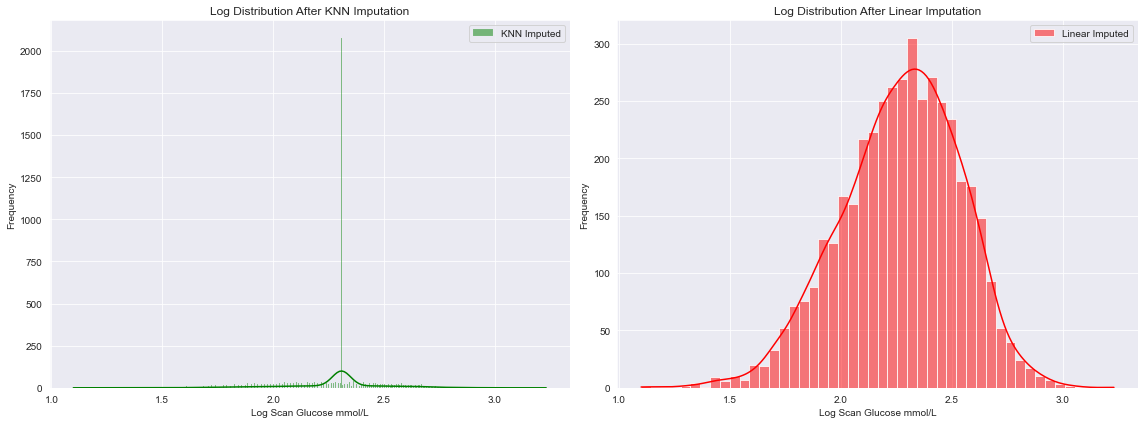

In [132]:
# Applying log transformation
df_imputed_knn['Log Scan Glucose mmol/L'] = np.log(df_imputed_knn['Scan Glucose mmol/L'])
df_imputed_linear['Log Scan Glucose mmol/L'] = np.log(df_imputed_linear['Scan Glucose mmol/L'])

# Plotting the distribution after log transformation
plt.figure(figsize=(16, 6))

# KNN Imputed Data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(df_imputed_knn['Log Scan Glucose mmol/L'], kde=True, color="green", label="KNN Imputed")
plt.title('Log Distribution After KNN Imputation')
plt.xlabel('Log Scan Glucose mmol/L')
plt.ylabel('Frequency')
plt.legend()

# Linear Imputed Data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df_imputed_linear['Log Scan Glucose mmol/L'], kde=True, color="red", label="Linear Imputed")
plt.title('Log Distribution After Linear Imputation')
plt.xlabel('Log Scan Glucose mmol/L')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

#### Checking for stationarity

In [133]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values:")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

# Example using df_imputed_linear
ad_test(df_imputed_linear['Log Scan Glucose mmol/L'].dropna())

1. ADF :  -8.208534741865558
2. P-Value :  6.918488611720207e-13
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression and Critical Values:
	 1% :  -3.4318917671161713
	 5% :  -2.862221267640611
	 10% :  -2.567132644174267


In [134]:

stepwise_fit = auto_arima(df_imputed_linear['Log Scan Glucose mmol/L'], trace=True,
                          suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3074.029, Time=5.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2377.787, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2382.967, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2385.545, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2379.783, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2935.078, Time=1.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3048.568, Time=6.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3069.816, Time=7.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3086.161, Time=8.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2872.934, Time=3.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-3050.033, Time=6.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2493.601, Time=0.87 sec
 ARIMA(0,1,4)(0,0,0)[0] interce

In [135]:
# Splitting the data into train and test sets for the linearly imputed and log-transformed data
train, test = train_test_split(df_imputed_linear, test_size=0.3, shuffle=False)


In [139]:
model = ARIMA(train['Log Scan Glucose mmol/L'], order=(2, 1, 4))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Log Scan Glucose mmol/L   No. Observations:                 2989
Model:                      ARIMA(2, 1, 4)   Log Likelihood                1295.692
Date:                     Mon, 25 Mar 2024   AIC                          -2577.385
Time:                             19:49:55   BIC                          -2535.368
Sample:                         09-23-2023   HQIC                         -2562.269
                              - 01-26-2024                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2140      0.244     -0.877      0.380      -0.692       0.264
ar.L2          0.4940      0.162      3.044      0.002       0.176       0.812
ma.L1          0.1899      0.245      0.776      0.438      -0.290       0.670
ma.L2         -0.7545      0.169     -4.463      0.000      -1.086      -0.423
ma.L3         -0.3104      0.064     -4.854      0.000      -0.436      -0.185
ma.L4         -0.1155      0.028     -4.124      0.000      -0.170      -0.061
sigma2         0.0246      0.000     73.505      0.000       0.024       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8211.23
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
forecast = model_fit.forecast(steps=len(test))
forecast = np.exp(forecast) 

In [141]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming test['Log Scan Glucose mmol/L'] is in log scale and needs to be reversed
actual = np.exp(test['Log Scan Glucose mmol/L'])

mse = mean_squared_error(actual, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 2.7149445810892177
MAE: 2.2739917785435626


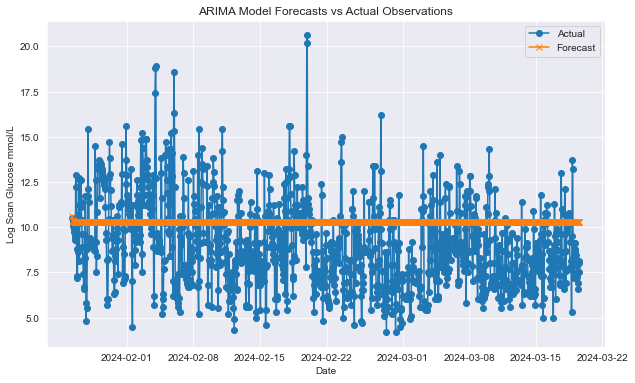

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Actual', marker='o')
plt.plot(actual.index, forecast, label='Forecast', marker='x')
plt.title('ARIMA Model Forecasts vs Actual Observations')
plt.xlabel('Date')
plt.ylabel('Log Scan Glucose mmol/L')
plt.legend()
plt.show()